# Import needed packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams.update({'figure.dpi': 120,'figure.figsize': (6,4)})

from pyQME.spectral_density import SpectralDensity
from pyQME.pump_probe import PumpProbeCalculator
from pyQME.tensors.markov import RedfieldTensor
from pyQME.tensors_double.markov import RedfieldTensorDouble
from pyQME.utils import overdamped_brownian,underdamped_brownian,get_timeaxis,wn2ips

# Define the system

**Hamiltonian (1/cm)**

In [7]:
nchrom = 2 #number of chromophores

coupling = 100
E0 = 10000
energy_gap = 500
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0      ,coupling     ])
H[1] = np.asarray([coupling,E0+energy_gap])

In [8]:
H

array([[10000.,   100.],
       [  100., 10500.]])

**Transition dipoles (Debye)**

In [9]:
dipoles = np.ones([nchrom,3])

**Temperature (Kelvin)**

In [10]:
temp = 298

**Spectral density**

In [11]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [12]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,518)

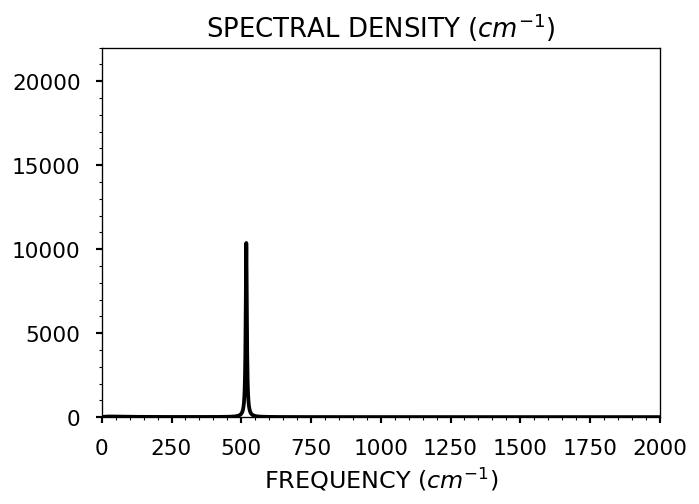

In [13]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [14]:
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Time axis (cm)**

In [15]:
energies = np.diag(H)
time_axis = get_timeaxis(SD_obj.Reorg,energies,5)
SD_obj.time = time_axis

**Relaxation Tensors**

In [16]:
rel_tens_obj = RedfieldTensor(H,SD_obj)
rel_tens_obj_double = RedfieldTensorDouble(H,SD_obj)

# Excited State Dynamics

**Load from file**

In [17]:
data = np.loadtxt('excited_state_dynamics/excited_state_dynamics.dat')
time_axis_ps = data[:,0]     #to be saved
rho_t_site_ = data[:,1:]
rho_t_site = rho_t_site_.reshape((time_axis_ps.size,nchrom,nchrom))

**Convert to exciton basis**

In [18]:
rho_t_exc = rel_tens_obj.transform(rho_t_site)

**Extract the population**

In [19]:
pop_t_exc = np.einsum('tkk->tk',rho_t_exc)

# Spectra calculation

In [20]:
spectrum_obj = PumpProbeCalculator(rel_tens_obj,rel_tens_obj_double)

In [21]:
spectrum_obj.calc_components_lineshape(dipoles=dipoles)
freq_axis,GSB_a,SE_a,ESA_a,PP_a = spectrum_obj.calc_pump_probe_OD_a(pop_t_exc) #to be saved
_,GSB,SE,ESA,PP = spectrum_obj.calc_pump_probe_OD(pop_t_exc) #to be saved

# Check the results

**Time after time**

**Exciton after exciton**

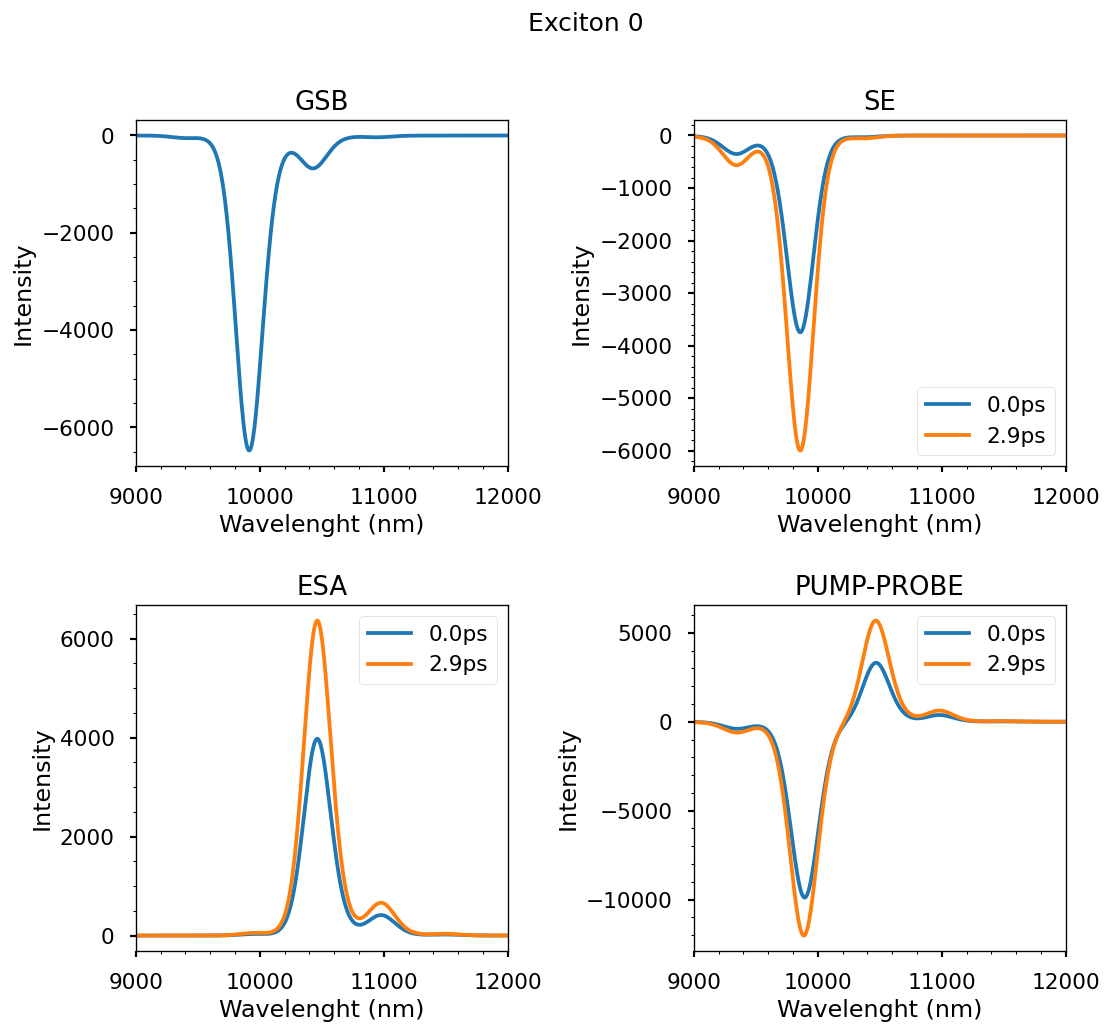

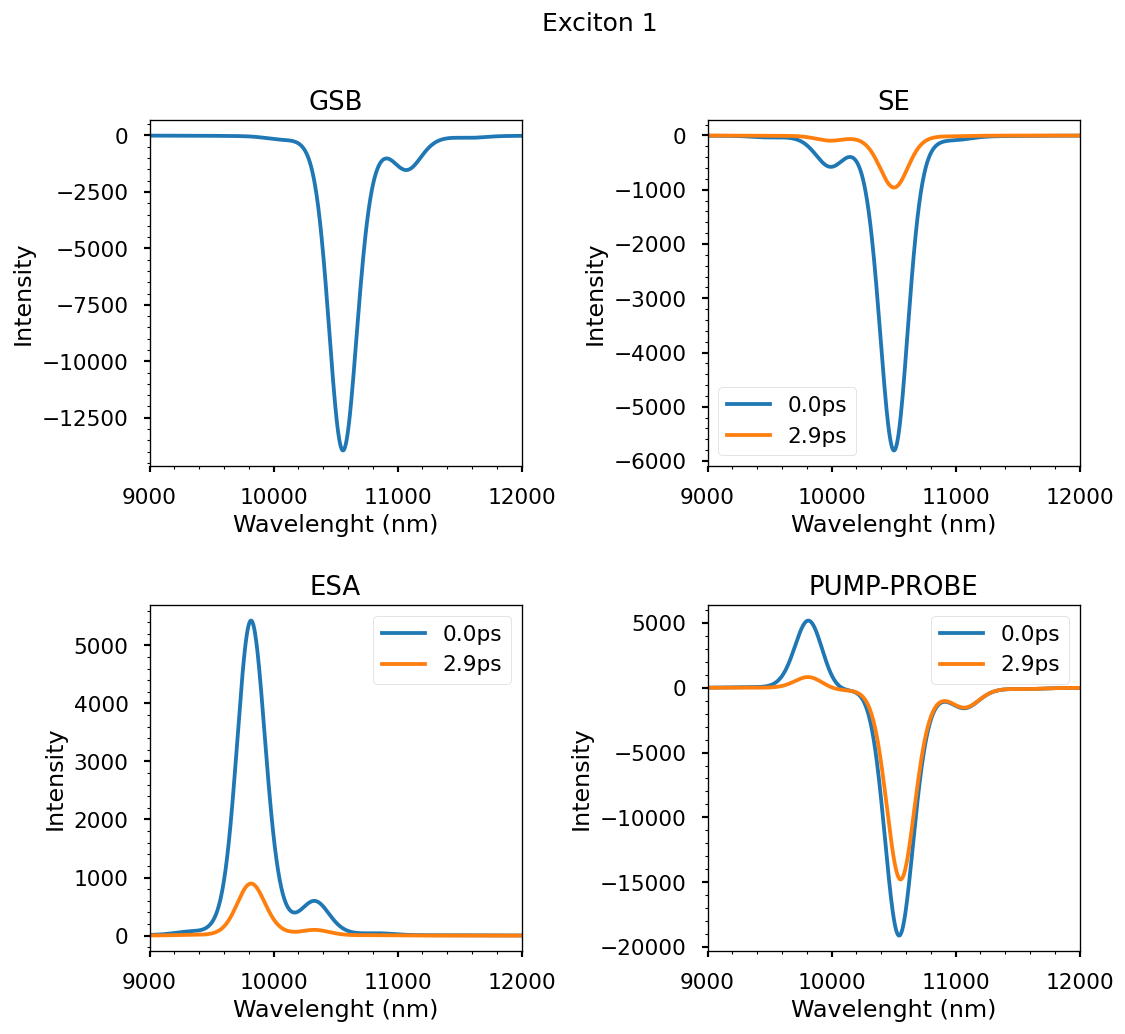

In [22]:
for exciton in range(nchrom):

    fig, axs = plt.subplots(2,2,gridspec_kw={'wspace': 0.5, 'hspace': 0.4})
    fig.set_size_inches(10,9)
    fig.suptitle('Exciton ' + str(exciton),size=15)
    
    #GSB
    axs[0,0].plot(freq_axis,GSB_a[exciton])
    axs[0,0].set_title('GSB')
    
    for time_idx,time in enumerate(time_axis_ps):
        
        time_string = str(time)+'ps'
        
        #SE
        axs[0,1].plot(freq_axis,SE_a[exciton,time_idx],label = time_string)
        axs[0,1].set_title('SE')

        #ESA
        axs[1,0].plot(freq_axis,ESA_a[exciton,time_idx],label = time_string)
        axs[1,0].set_title('ESA')

        #FULL
        axs[1,1].set_title('PUMP-PROBE')
        axs[1,1].plot(freq_axis,PP_a[exciton,time_idx],label = time_string)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlim(9000,12000)
            ax2.minorticks_on()
            ax2.set_xlabel("Wavelenght (nm)")
            ax2.set_ylabel("Intensity")
            if not ax2 == axs[0,0]:
                ax2.legend()